In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
from pathlib import Path
root_path = Path.cwd().parent.absolute()
print(root_path)
import sys
sys.path.append(str(root_path))
sys.path.append(Path.cwd())
os.getcwd()

/work/Sebas/BV_Hamiltonian


'/work/Sebas/BV_Hamiltonian/Parametric_BV_Hamiltonian'

In [2]:
import jax
import flax
from jax import random
from flax import nnx

In [3]:
key = jax.random.PRNGKey(1234)

key, subkey = jax.random.split(key)
d = 2
n_samples = 10

z_samples = jax.random.normal(subkey, (n_samples, d))
z_samples.shape

(10, 2)

In [4]:
from architectures.architectures import MLP
from architectures.node import NeuralODE


In [64]:
key, subkey = jax.random.split(key)
rngs = nnx.Rngs(subkey)

mlp = MLP(din=2, num_layers=10, width_layers=128, dout=2, activation_fn="tanh",rngs=rngs)



In [65]:
node = NeuralODE(mlp,solver = "euler",dt0=0.1,time_dependent=False)

# graphdef, initial_params = nnx.split(node)  
# scaled_params = jax.tree.map(lambda x: 1e-4 * x, initial_params)
# node = nnx.merge(graphdef, scaled_params)

In [66]:
z_samples

Array([[-0.0488972 , -0.24350879],
       [ 0.90381616, -2.5325677 ],
       [-1.0998387 , -1.079322  ],
       ...,
       [-0.33238816, -0.92406476],
       [ 0.32488984,  1.1810111 ],
       [-0.04982525,  0.9227235 ]], dtype=float32)

In [67]:
xt, t_list = node(z_samples, t_span=(0.0, 1.0), history=True)
xT = xt[:, -1, :]
xT

Array([[ 1.90152274e-03, -2.45327026e-01],
       [ 1.18388236e+00, -2.65227890e+00],
       [-8.93646598e-01, -1.01334250e+00],
       ...,
       [-1.52528837e-01, -9.21191514e-01],
       [ 1.06469005e-01,  1.19307959e+00],
       [-2.24653527e-01,  9.67510343e-01]], dtype=float32)

In [68]:
xt[:,0,:]

Array([[-0.0488972 , -0.24350879],
       [ 0.90381616, -2.5325677 ],
       [-1.0998387 , -1.079322  ],
       ...,
       [-0.33238816, -0.92406476],
       [ 0.32488984,  1.1810111 ],
       [-0.04982525,  0.9227235 ]], dtype=float32)

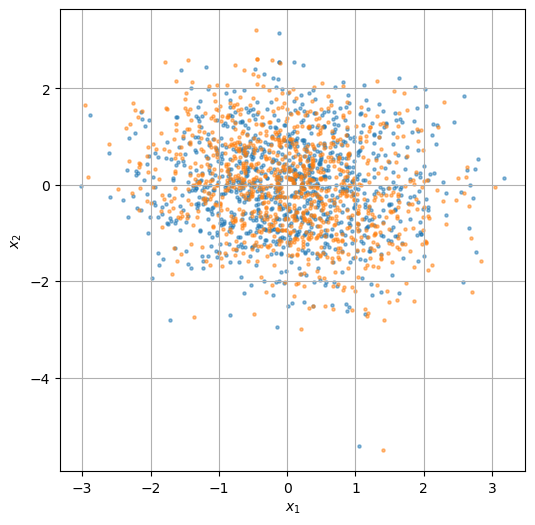

In [69]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.scatter(z_samples[:,0], z_samples[:,1], s=5, alpha=0.5)
plt.scatter(xT[:,0], xT[:,1], s=5, alpha=0.5)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
# plt.title("Samples from the learned distribution")
plt.grid()

In [70]:
import jax.numpy as jnp

In [71]:
from time import time
t0 = time()
score_exact = node.score_function(t_list, xt, method="exact",    score_trajectory=False)
t1 = time()
print("Exact score time:", t1 - t0)
t0 = time()
score_auto  = node.score_function(t_list, xt, method="autodiff", score_trajectory=False)
t1 = time()
print("Autodiff score time:", t1 - t0)


Exact score time: 0.5842273235321045


2025-09-29 19:09:17.160955: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-09-29 19:09:18.637746: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


Autodiff score time: 3.490076780319214


In [72]:
z_samples

Array([[-0.0488972 , -0.24350879],
       [ 0.90381616, -2.5325677 ],
       [-1.0998387 , -1.079322  ],
       ...,
       [-0.33238816, -0.92406476],
       [ 0.32488984,  1.1810111 ],
       [-0.04982525,  0.9227235 ]], dtype=float32)

In [73]:
diff = jnp.mean(jnp.abs(score_exact - score_auto))
print("max |exact - autodiff| =", float(diff))


max |exact - autodiff| = 0.0010776661802083254


In [74]:
print(score_exact)


[[ 0.09909404  0.24443032]
 [-0.74579775  2.526682  ]
 [ 1.1950251   1.1927404 ]
 ...
 [ 0.4858789   0.9481726 ]
 [-0.5065878  -1.1934842 ]
 [-0.10501572 -0.8874456 ]]


In [75]:
print(score_auto)

[[ 0.09879969  0.24344145]
 [-0.7505892   2.5258527 ]
 [ 1.1960629   1.1920557 ]
 ...
 [ 0.4865297   0.9462922 ]
 [-0.5077169  -1.1915998 ]
 [-0.10434727 -0.88536704]]


In [17]:
from parametric_model.parametric_model import ParametricModel

In [23]:
# Define the parametric model
parametric_model = ParametricModel(
    parametric_map="node", # "node" "resnet"
    architecture=[2, 2, 128], # [input_dim, num_layers, hidden_width]
    time_dependent=True,    # True or False
    solver="euler", # "euler" or "heun"
    dt0=0.01,
    rhs_model="mlp", # "mlp" or "resnet"
    ref_density="gaussian",
    scale_factor=1e-4
)

In [24]:
key, subkey = jax.random.split(key)
d = 2
n_samples = 1000

z_samples = jax.random.normal(subkey, (n_samples, d))

xt, t_list = parametric_model(z_samples, history=True)

2025-09-29 19:05:17.385301: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


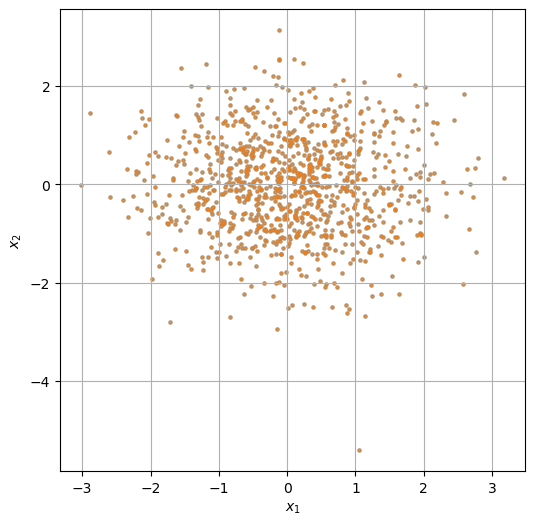

In [25]:
plt.figure(figsize=(6,6))
plt.scatter(z_samples[:,0], z_samples[:,1], s=5, alpha=0.5)
plt.scatter(xt[:,-1,0], xt[:,-1,1], s=5, alpha=0.5)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
# plt.title("Samples from the learned distribution")
plt.grid()

In [26]:
score_exact = parametric_model.score_function(t_list, xt, method="exact")

2025-09-29 19:05:18.672695: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-09-29 19:05:19.960087: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


In [22]:
score_autodiff = parametric_model.score_function(t_list, xt, method="autodiff")

KeyboardInterrupt: 

In [ ]:
diff = jnp.max(jnp.abs(score_exact - score_autodiff))
print("max |exact - autodiff| =", float(diff))

max |exact - autodiff| = 0.005993783473968506
